In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [13]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests, plot_corr = True):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
    if plot_corr:
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_neg_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [('-', inp), '=']
        trial.append(-1*cue_dict[inp])
        seq.append(trial)
    return seq


# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)
    
def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[0])
        j = map_syms.index(eval(trial)[2])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


# RNN setup

In [24]:
## running function

def run_exp(trainseqs_old, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    
    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list = [r['acc'][:,1] for r in res]
    loss_list = [r['loss'] for r in res]
    losses = np.hstack(loss_list)
    acc_train = np.array(acc_train_list).T
    acc_test = np.array(acc_test_list).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    ft_tests_acc = np.array([acc_test_list[i] for i in fully_trained_idx]).T
    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0
    
    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)


    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc, 2),  '\n-----------\n')

    return {'res':res, 'r2': r2, 'all_final_accs': final_accs, 'mean_acc_final': fully_trained_test_acc,\
            'all_dfs':alldfs, 'df_trials': dfs, 'acc_std': fully_trained_test_acc_std}


In [25]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 50
learningRate = 0.005

## running params
epochs = 1000
num_sims = 104

In [27]:
ops = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)
print(p_neg)

{'A': 15, 'B': 7, 'C': 11, 'D': 6}
[[('-', 'A'), '=', -15], [('-', 'B'), '=', -7], [('-', 'C'), '=', -11], [('-', 'D'), '=', -6]]


trainseqs  [['A', ('-', 'B'), '=', 8], ['B', ('-', 'C'), '=', -4], ['C', ('-', 'D'), '=', 5], ['D', ('-', 'A'), '=', -9], ['A', '=', 15], ['B', '=', 7], ['C', '=', 11], ['D', '=', 6], [('-', 'A'), '=', -15], [('-', 'B'), '=', -7], [('-', 'C'), '=', -11], [('-', 'D'), '=', -6]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 4], ['A', ('-', 'D'), '=', 9], ['B', ('-', 'A'), '=', -8], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', 1], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', 4], ['C', ('-', 'C'), '=', 0], ['D', ('-', 'B'), '=', -1], ['D', ('-', 'C'), '=', -5], ['D', ('-', 'D'), '=', 0]]
run time:  4.0544895013173425
6
total time:  4.0565383990605675
6 / 16  rnns trained to 100% accuracy.        
 Mean test acc =  0.07 
-----------



label      pred       acc
trial                                             
['A', '-', 'C', '='] -1.000000  0.778963  0.333333
['A', '-', 'D', '='] -1.166667  0.113040  0.166667
['B', '-', 'A', '='] -1.000000 -1.521924  0.166667
['B', '-', 'D', '='] -2.166667 -2.104839  0.166667
['A', '-', 'A', '=']  0.000000  0.204478  0.000000
['B', '-', 'B', '=']  0.000000 -1.217390  0.000000
['C', '-', 'A', '=']  1.000000  0.497992  0.000000
['C', '-', 'B', '=']  2.000000  1.471212  0.000000
['C', '-', 'C', '=']  0.000000  1.538198  0.000000
['D', '-', 'B', '=']  2.166667  1.734346  0.000000
['D', '-', 'C', '=']  0.166667  1.651567  0.000000
['D', '-', 'D', '=']  0.000000  1.506369  0.000000

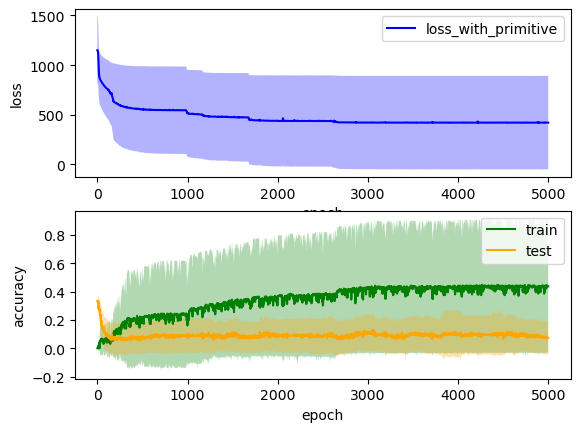

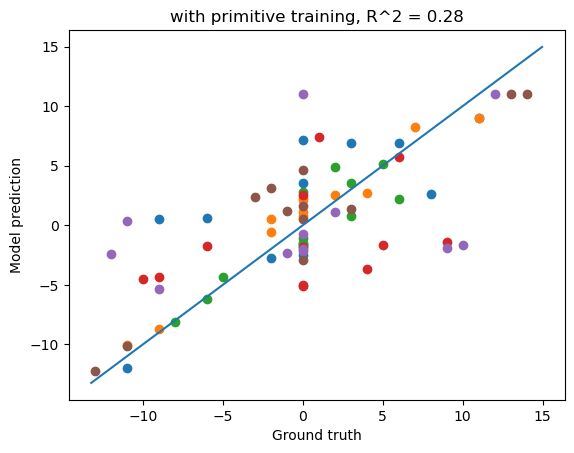

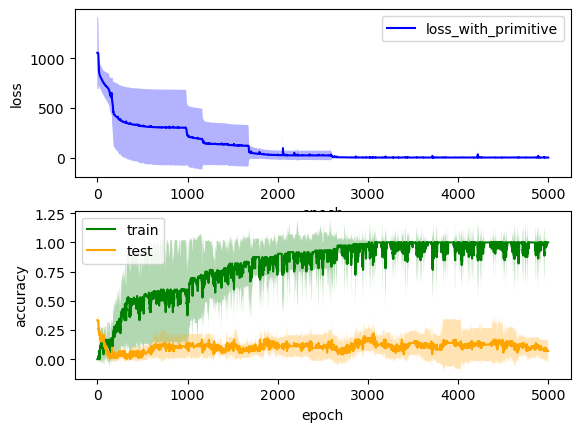

In [33]:
# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 5000
num_sims = 16

trainseqs = generate_other(ops, all_syms) + p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 8], ['A', ('-', 'C'), '=', 4], ['B', ('-', 'A'), '=', -8], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -4], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', 4], ['C', ('-', 'C'), '=', 0], ['A', '=', 15], ['B', '=', 7], ['C', '=', 11], ['D', '=', 6], [('-', 'A'), '=', -15], [('-', 'B'), '=', -7], [('-', 'C'), '=', -11], [('-', 'D'), '=', -6]]
testseqs  [['A', ('-', 'D'), '=', 9], ['B', ('-', 'D'), '=', 1], ['C', ('-', 'D'), '=', 5], ['D', ('-', 'A'), '=', -9], ['D', ('-', 'B'), '=', -1], ['D', ('-', 'C'), '=', -5], ['D', ('-', 'D'), '=', 0]]
run time:  6.412115502357483
6
total time:  6.413597548007965
6 / 16  rnns trained to 100% accuracy.        
 Mean test acc =  0.19 
-----------



label      pred       acc
trial                                             
['C', '-', 'D', '=']  1.000000  2.221482  0.500000
['A', '-', 'D', '='] -4.000000 -2.676316  0.166667
['B', '-', 'D', '='] -1.833333  1.077604  0.166667
['D', '-', 'B', '=']  1.833333  0.363552  0.166667
['D', '-', 'C', '='] -1.000000 -2.747940  0.166667
['D', '-', 'D', '=']  0.000000  1.923919  0.166667
['D', '-', 'A', '=']  4.000000  2.462054  0.000000

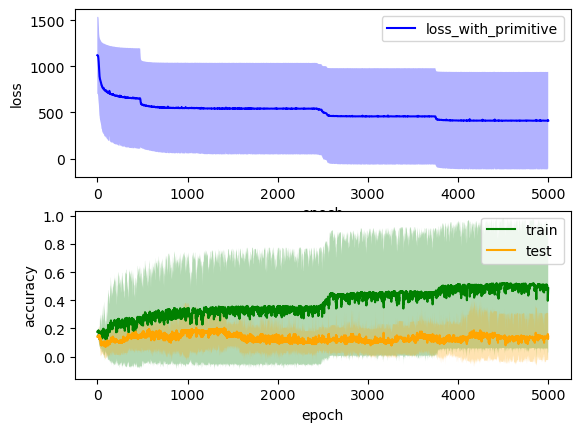

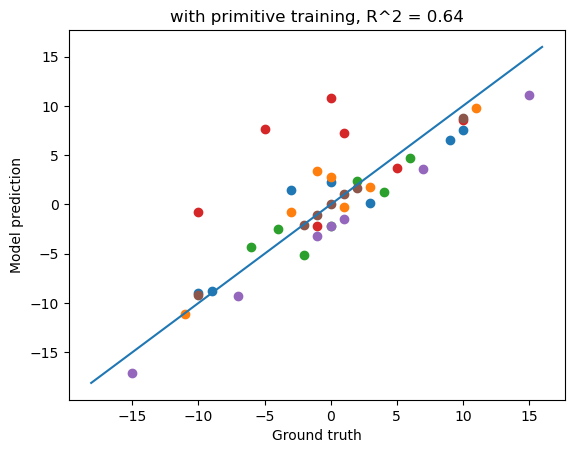

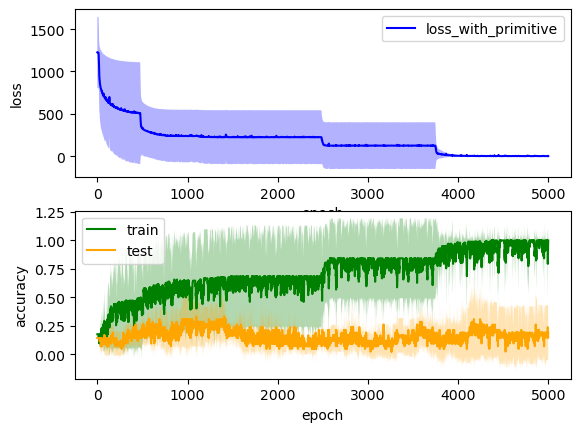

In [34]:
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1]) + p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res2 = run_plot(trainseqs, testseqs, cue_dict)
df2 = res2['df_trials']
df2

In [ ]:
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1]) + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res3 = run_plot(trainseqs, testseqs, cue_dict)
df3 = res3['df_trials']
df3

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 8], ['A', ('-', 'C'), '=', 4], ['B', ('-', 'A'), '=', -8], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -4], ['C', ('-', 'A'), '=', -4], ['C', ('-', 'B'), '=', 4], ['C', ('-', 'C'), '=', 0], [('-', 'A'), '=', -15], [('-', 'B'), '=', -7], [('-', 'C'), '=', -11], [('-', 'D'), '=', -6]]
testseqs  [['A', ('-', 'D'), '=', 9], ['B', ('-', 'D'), '=', 1], ['C', ('-', 'D'), '=', 5], ['D', ('-', 'A'), '=', -9], ['D', ('-', 'B'), '=', -1], ['D', ('-', 'C'), '=', -5], ['D', ('-', 'D'), '=', 0]]


In [29]:
num_sims = 80
ops = '-'

num_inputs = 2
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)
print(p_neg)

{'A': 10, 'B': 13}
[[('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]


# Just positive primitive Training

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0]]
run time:  1.1195101698239645
78
total time:  1.1234320839246115
78 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.18 
-----------

trainseqs:  [['A', ('-', 'B'), '=', -3], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0]]
run time:  1.9800715486208598
80
total time:  1.9863759795824687
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------

trainseqs:  [['B', ('-', 'A'), '=', 3], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['B', ('-', 'B'), '=', 0]]
run time:  1.9987446467081706
79
total time:  2.004328401883443
79 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------

trainseqs:  [['B', ('-', 'B'), '=', 0], ['A', '=', 10],

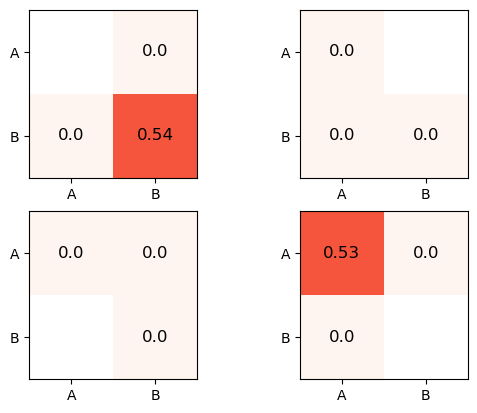

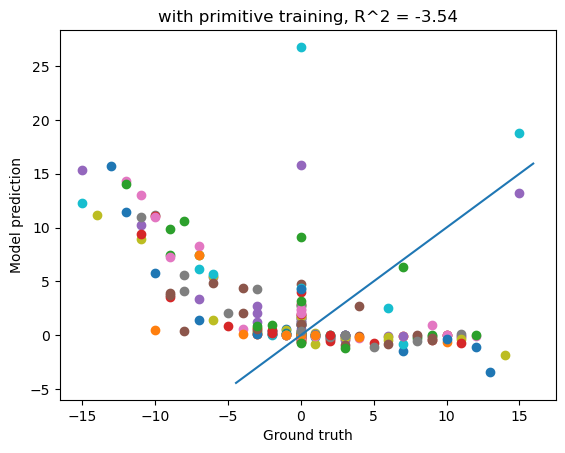

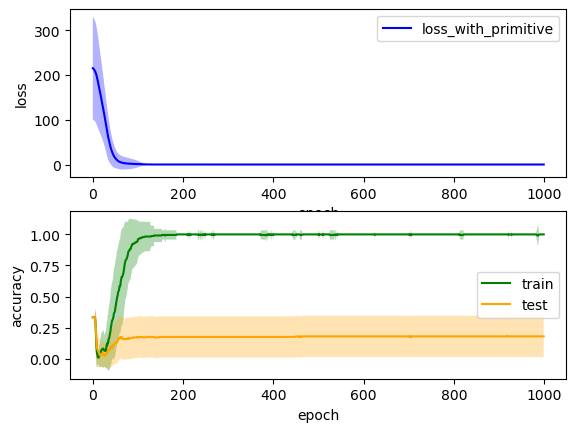

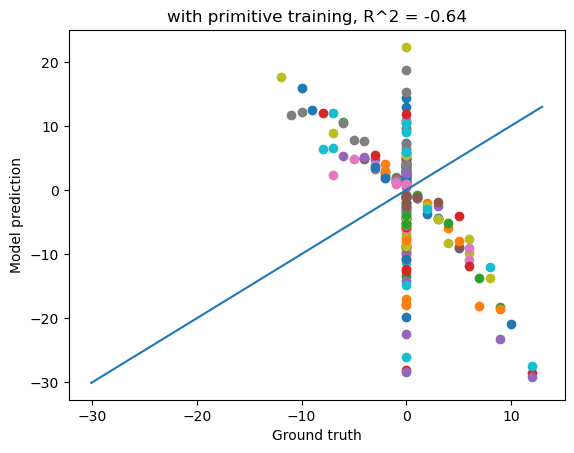

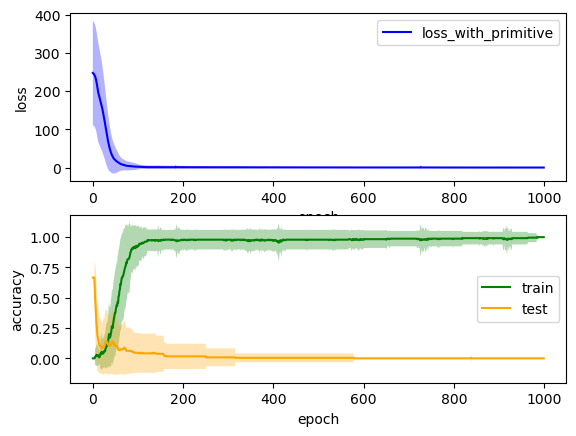

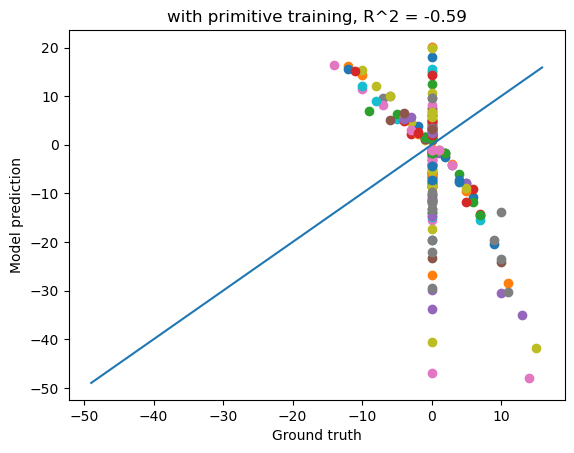

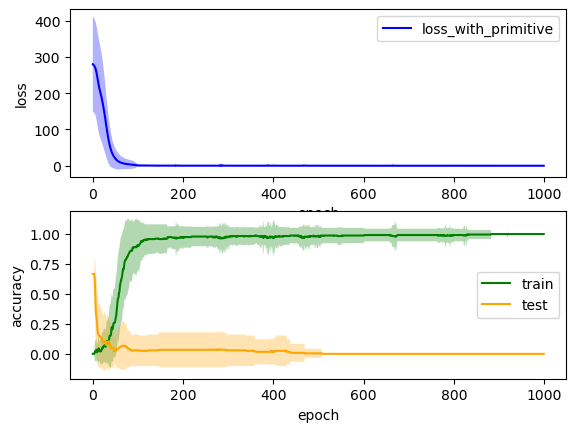

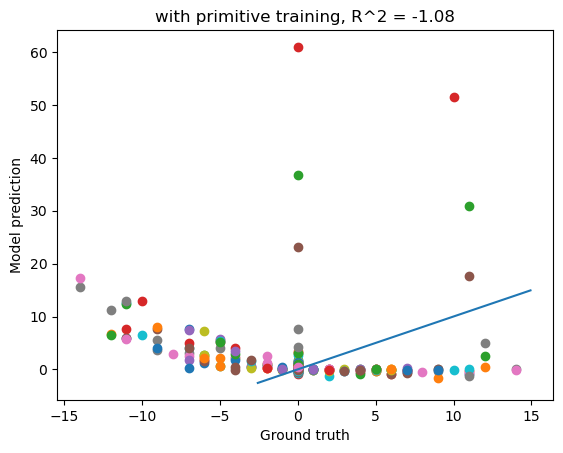

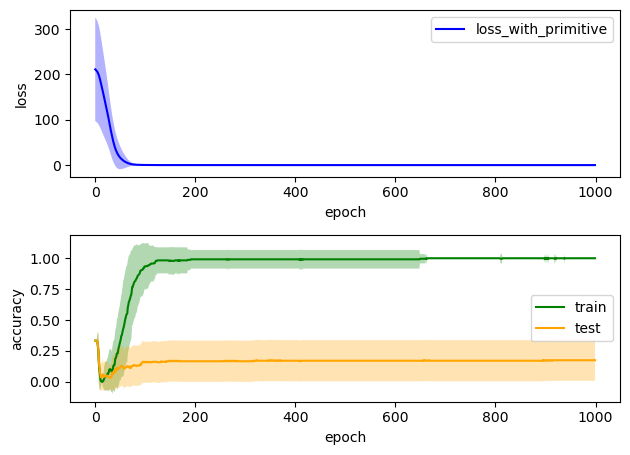

In [30]:
## primitive training
num_train = 1

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0]]
run time:  1.3096792658170064
76
total time:  1.3132909138997395
76 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.04 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', 3], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'B'), '=', 0]]
run time:  1.2276340166727702
69
total time:  1.2303781986236573
69 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.01 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'A'), '=', 3]]
run time:  2.1916433811187743
80
total time:  2.195697863896688
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------

trainseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', '

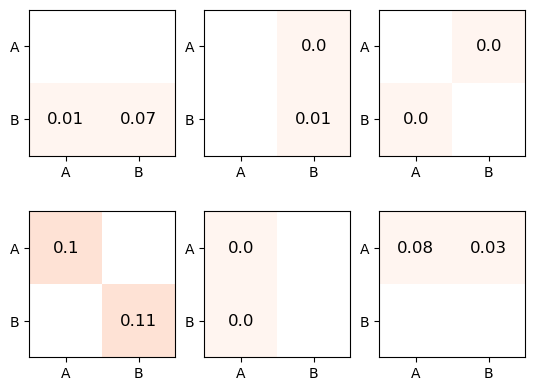

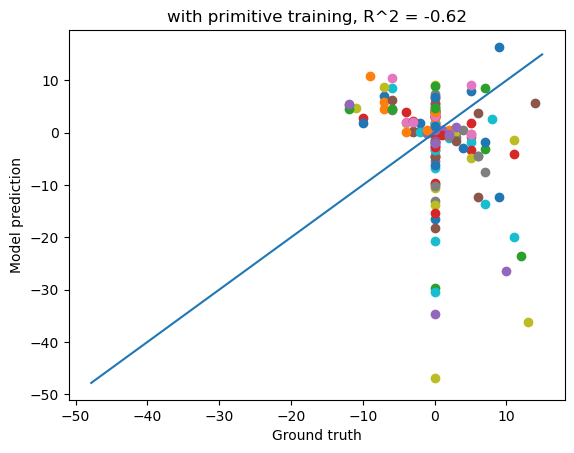

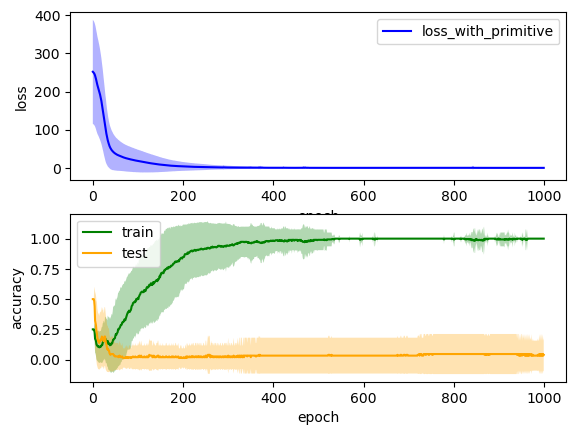

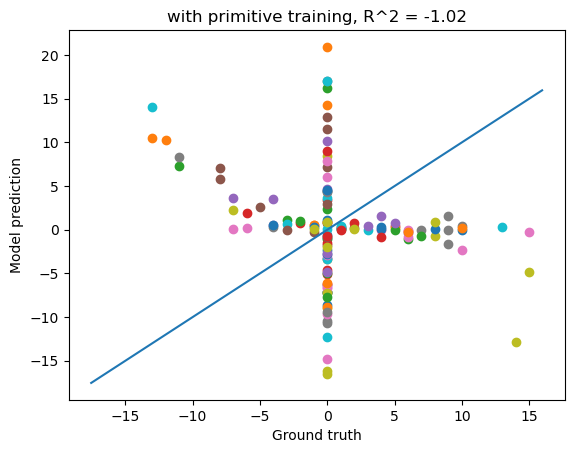

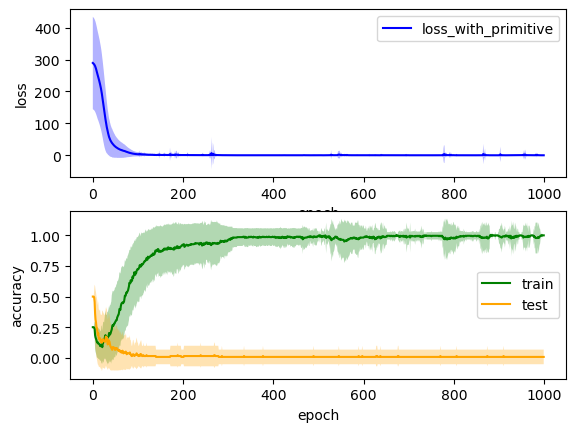

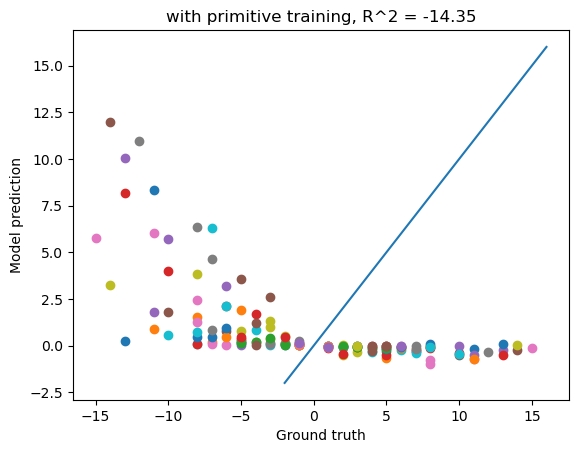

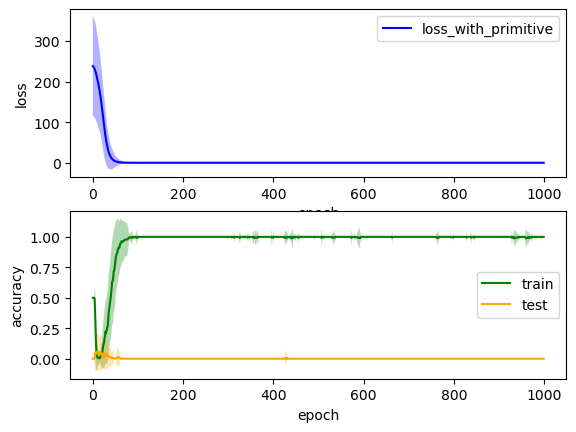

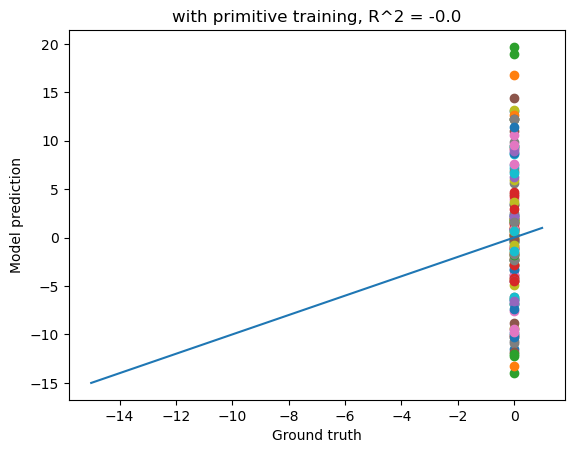

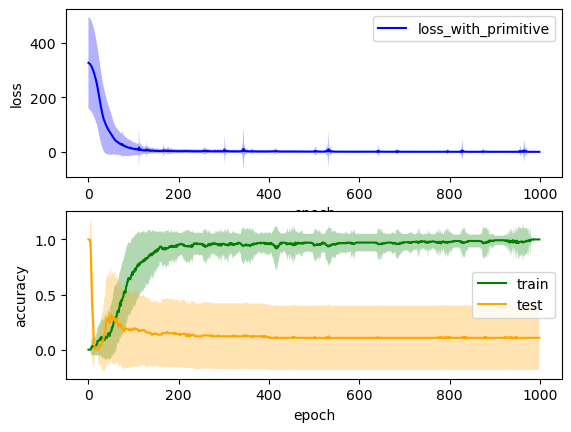

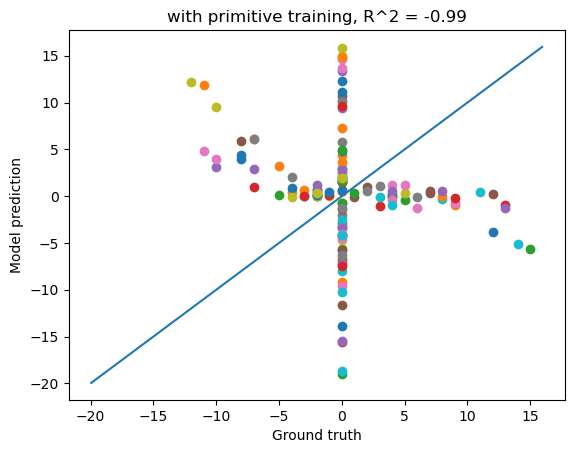

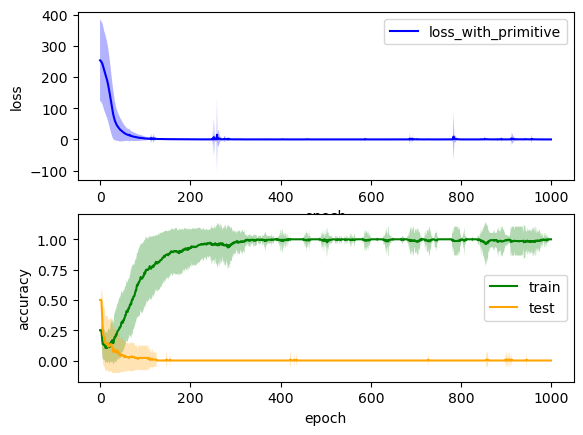

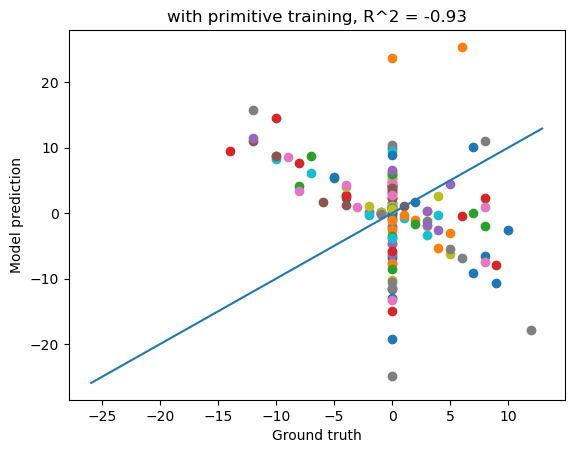

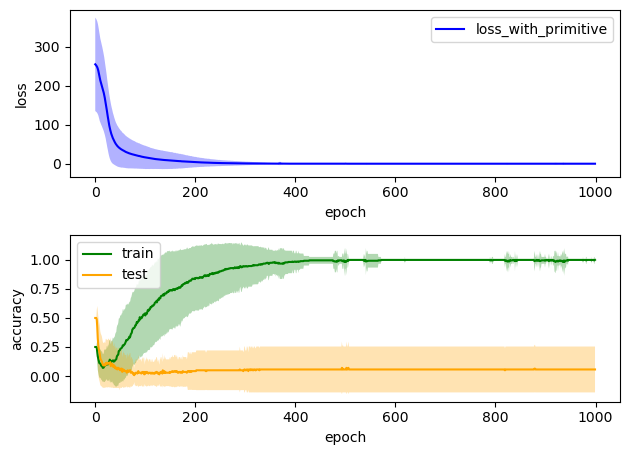

In [31]:
## primitive training
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 3
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['B', ('-', 'A'), '=', 3], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['B', ('-', 'B'), '=', 0]]
run time:  1.67766383488973
72
total time:  1.6807641983032227
72 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.28 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['B', ('-', 'B'), '=', 0], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['B', ('-', 'A'), '=', 3]]
run time:  1.5585960308710733
76
total time:  1.5638034145037334
76 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.12 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0], ['A', '=', 10], ['B', '=', 13]]
testseqs:  [['A', ('-', 'B'), '=', -3]]
run time:  1.471889281272888
71
total time:  1.4745054165522258
71 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.13 
-----------

trainseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'A

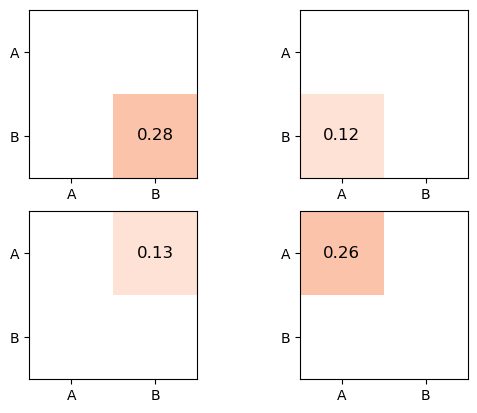

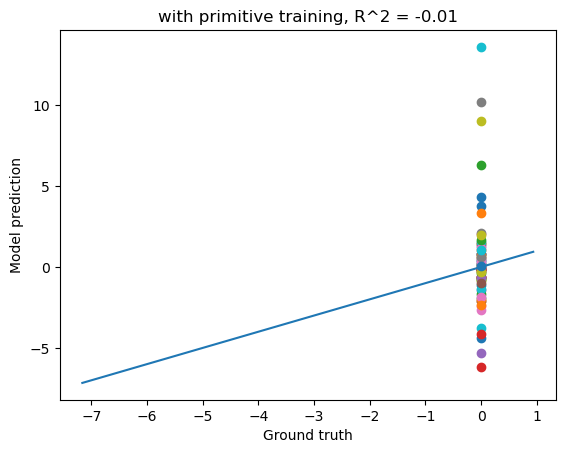

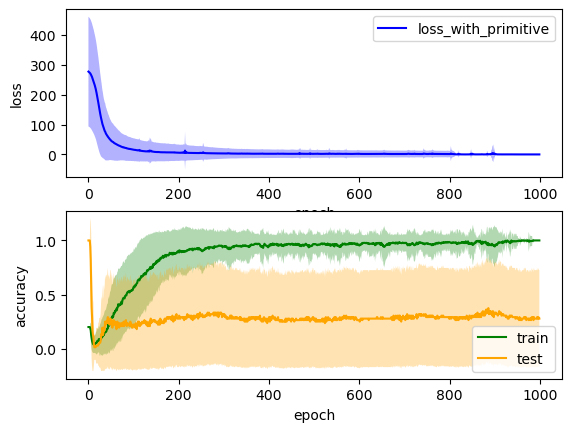

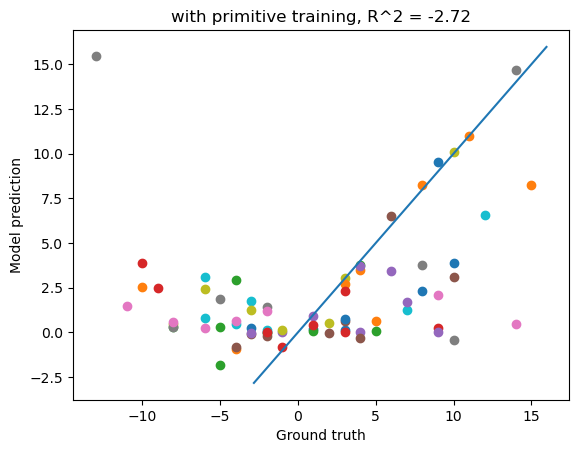

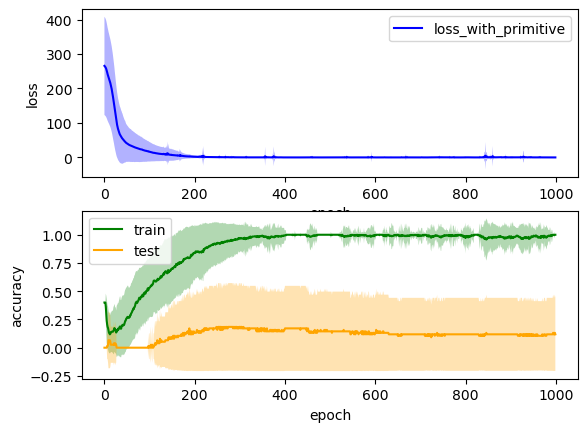

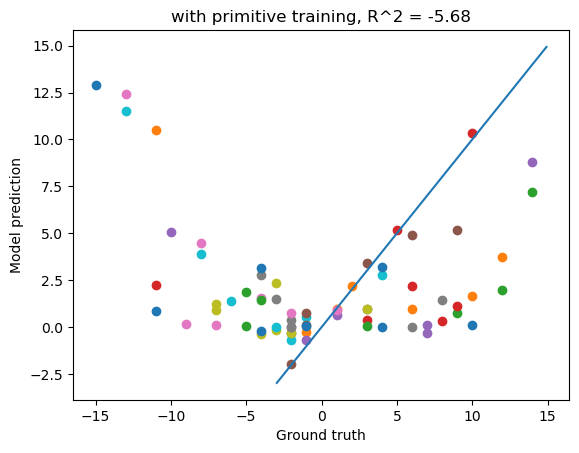

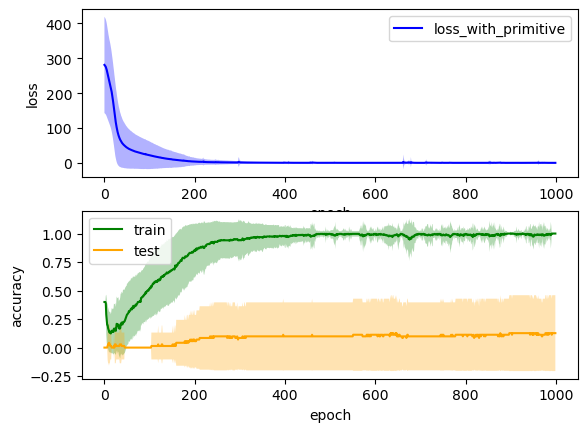

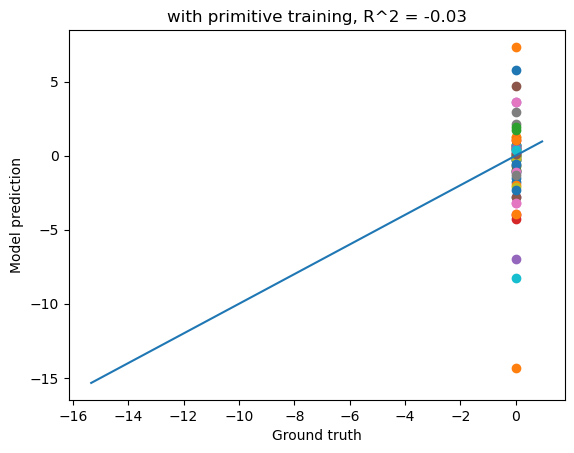

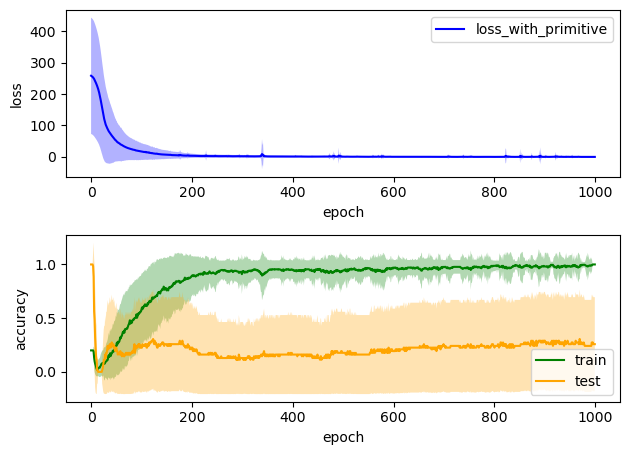

In [37]:
## primitive training
num_train = 3

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

# Full primitive Training

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0]]
run time:  1.54217023452123
74
total time:  1.5456228335698445
74 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.08 
-----------

trainseqs:  [['A', ('-', 'B'), '=', -3], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0]]
run time:  1.491574768225352
67
total time:  1.49475599527359
67 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.06 
-----------

trainseqs:  [['B', ('-', 'A'), '=', 3], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['B', ('-', 'B'), '=', 0]]
run time:  1.463358497619629
67
total time:  1.46651082833608
6

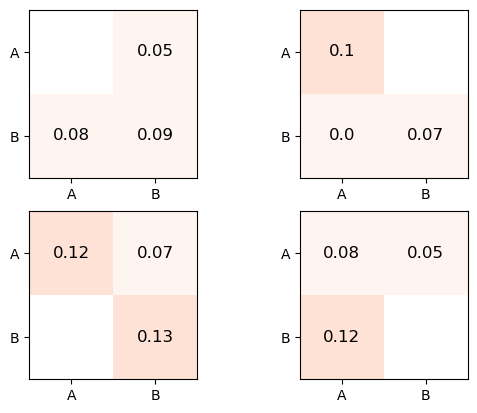

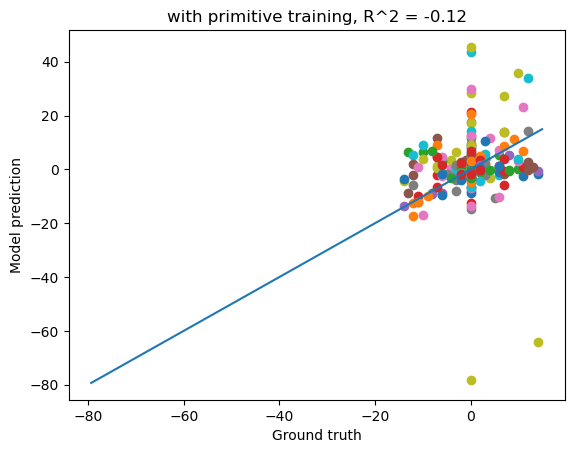

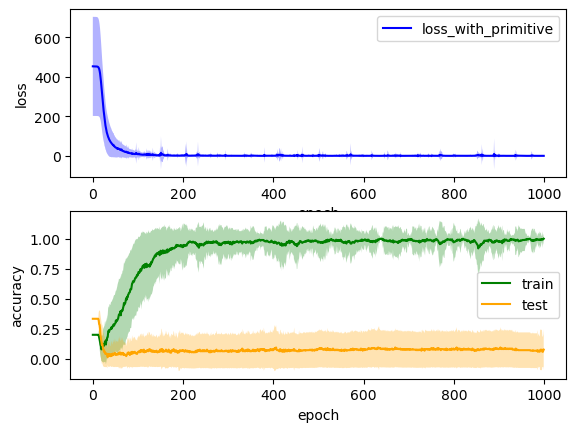

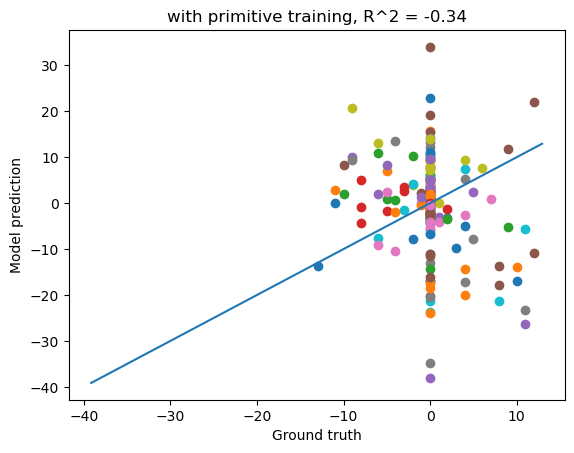

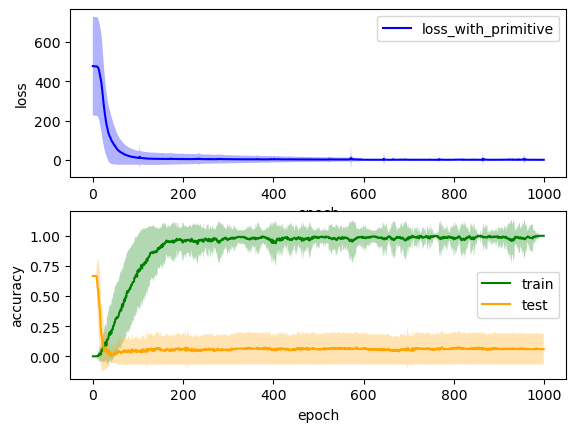

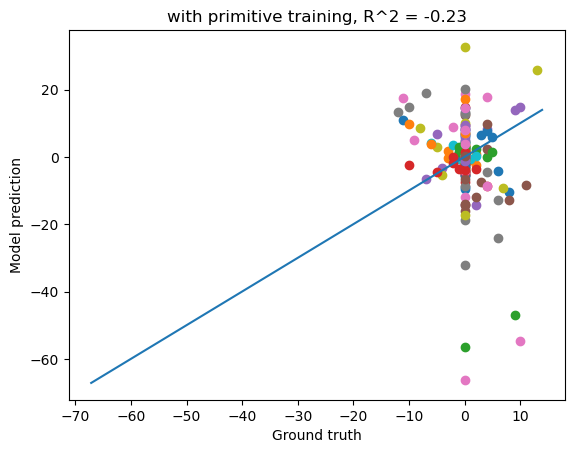

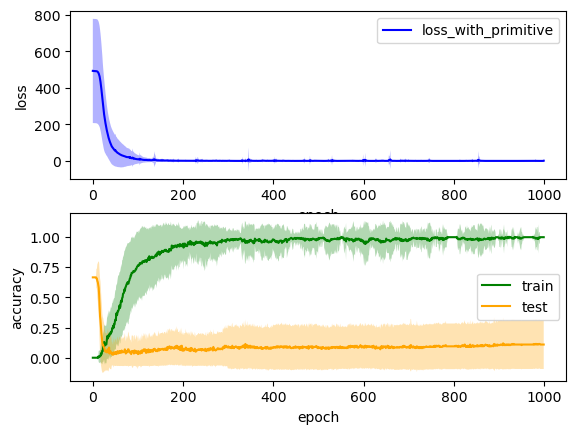

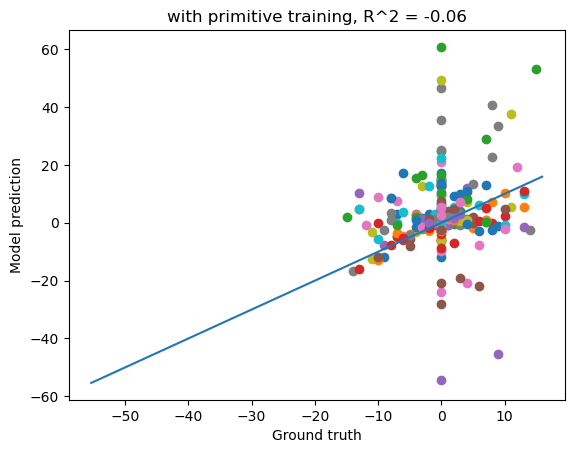

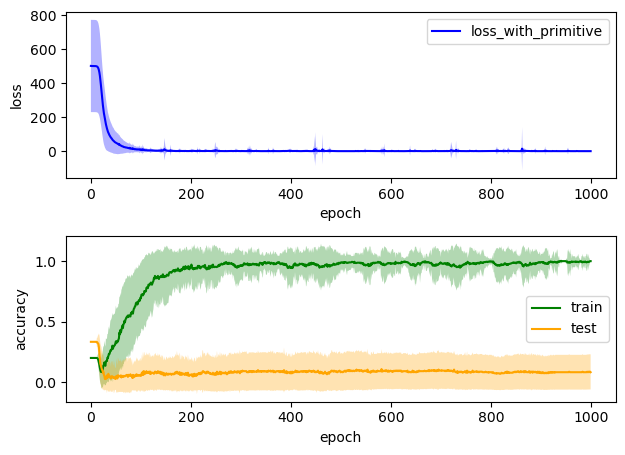

In [33]:
## primitive training
num_train = 1

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p + p_neg
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0]]
run time:  1.6751071492830911
60
total time:  1.6775628169377645
60 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.04 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', 3], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'B'), '=', 0]]
run time:  1.6405431350072226
66
total time:  1.64462468624115
66 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.11 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['A', ('-', 'B'), '=', -3], ['B', ('-', 'A'), '=', 3]]
run time:  1.6598994493484498
69
total time:  1.662735736370

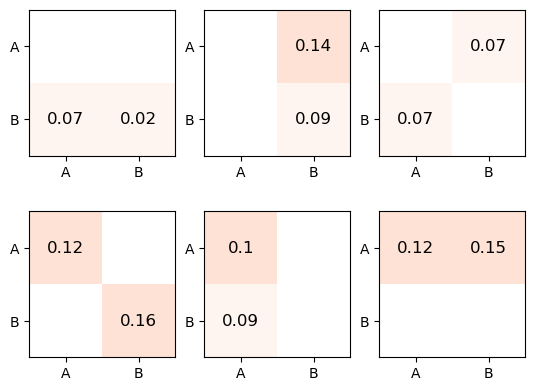

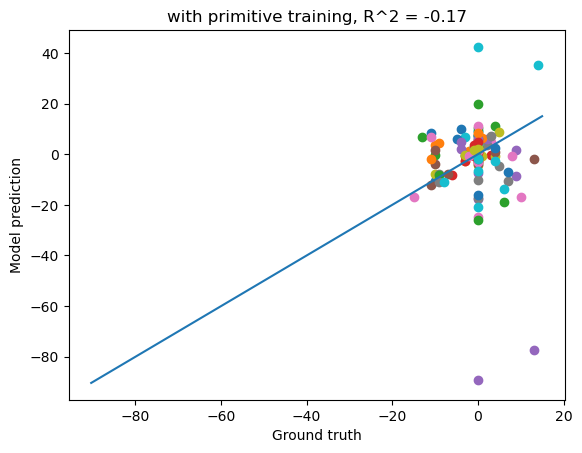

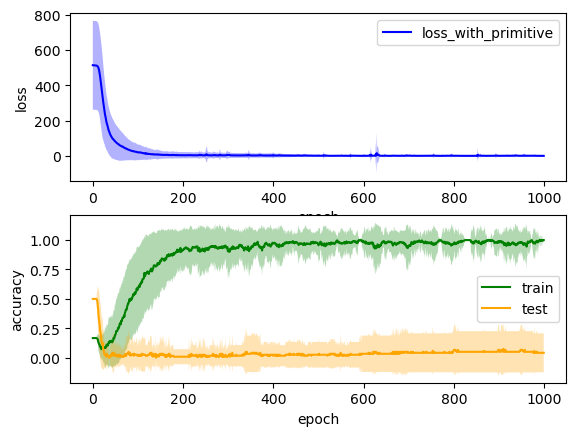

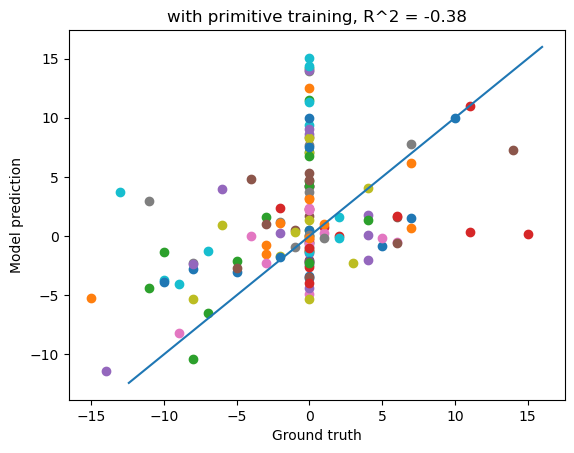

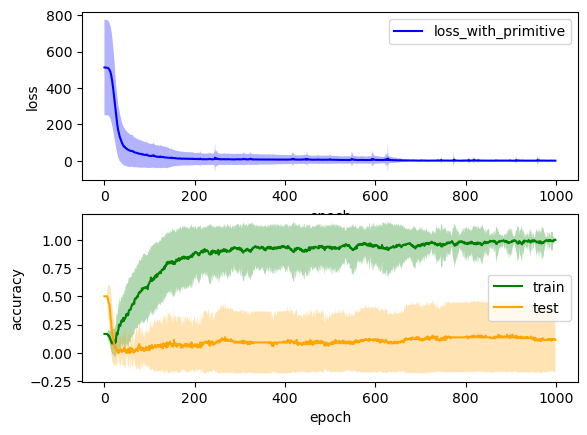

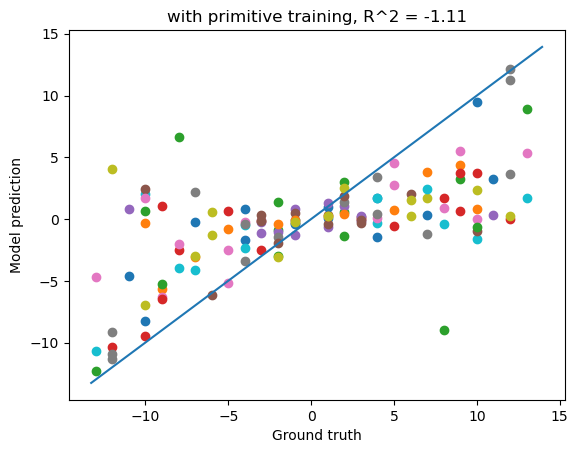

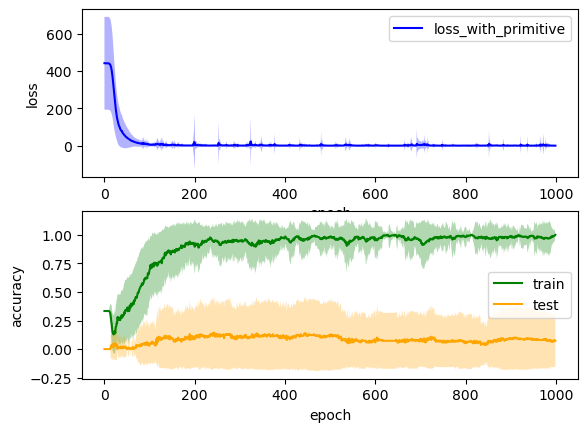

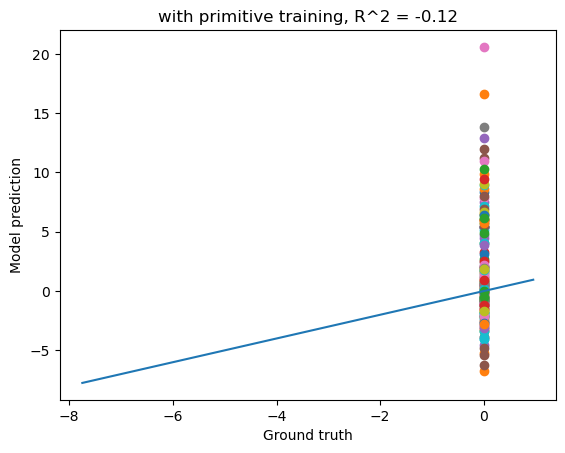

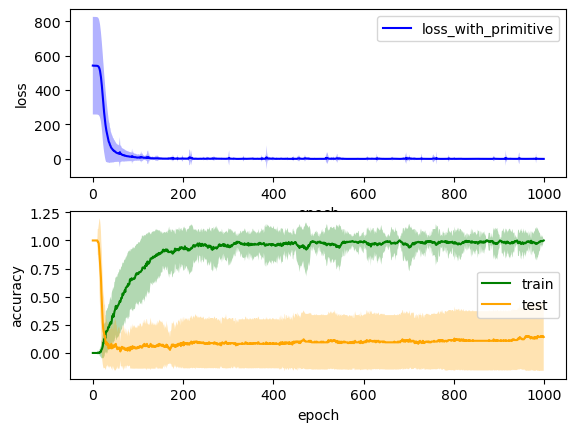

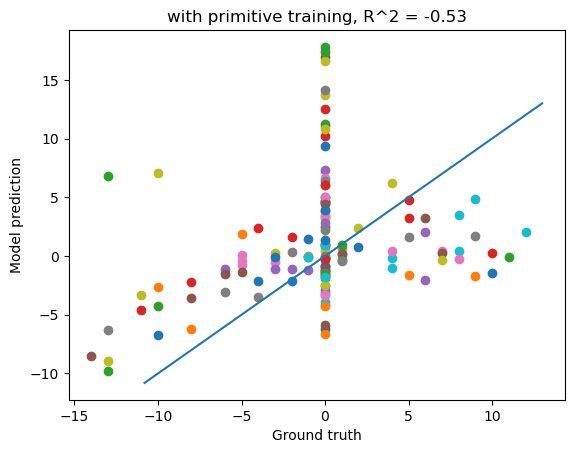

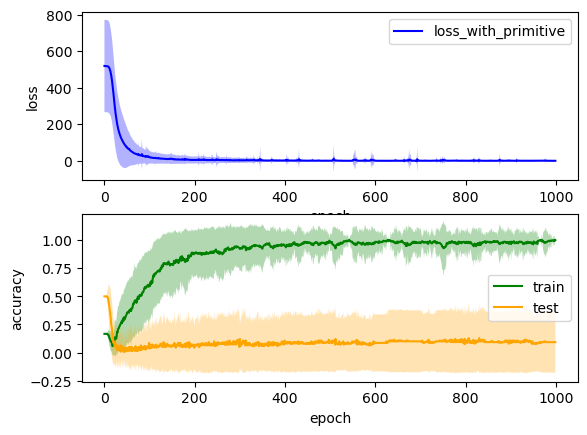

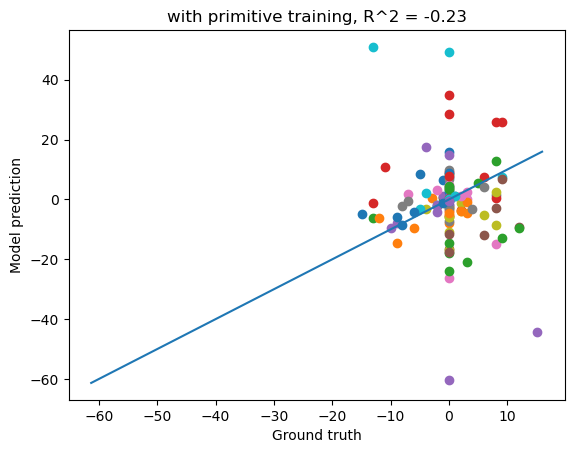

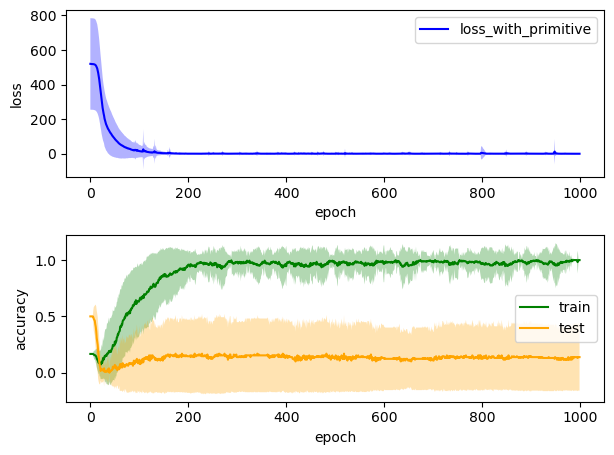

In [34]:
## primitive training
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 3
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p + p_neg
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['B', ('-', 'A'), '=', 3], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['B', ('-', 'B'), '=', 0]]
run time:  1.9831013321876525
74
total time:  1.9859498659769694
74 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.46 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -3], ['B', ('-', 'B'), '=', 0], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['B', ('-', 'A'), '=', 3]]
run time:  1.8705338676770529
67
total time:  1.8752652168273927
67 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.63 
-----------

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', 3], ['B', ('-', 'B'), '=', 0], ['A', '=', 10], ['B', '=', 13], [('-', 'A'), '=', -10], [('-', 'B'), '=', -13]]
testseqs:  [['A', ('-', 'B'), '=', -3]]
run time:  2.213085166613261
65
total time:  2.21613384882

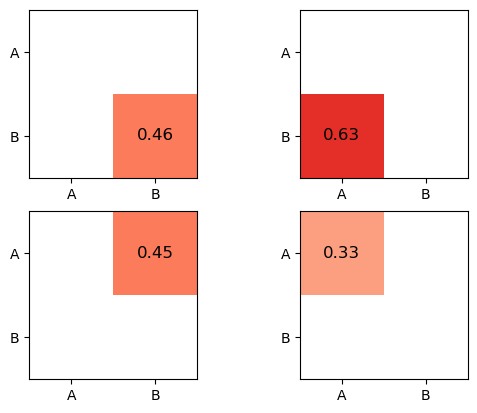

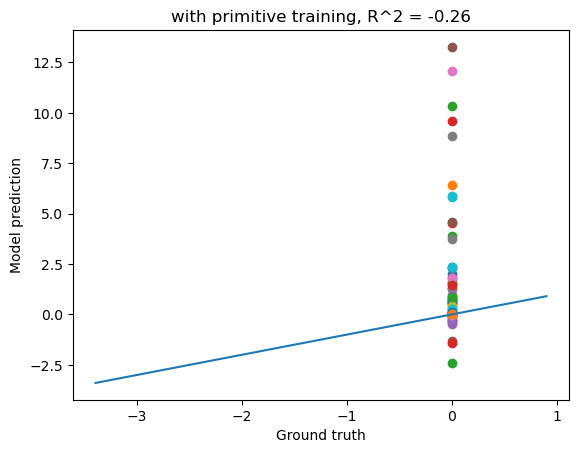

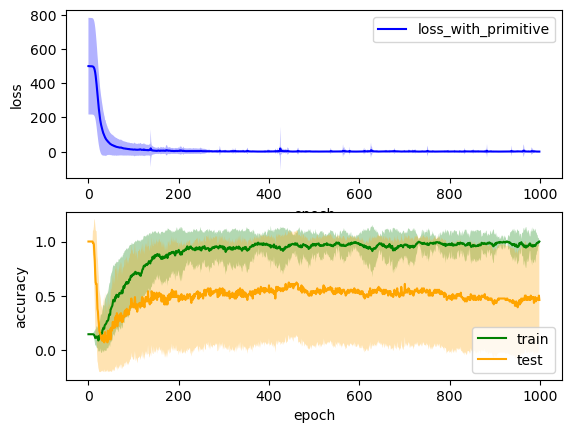

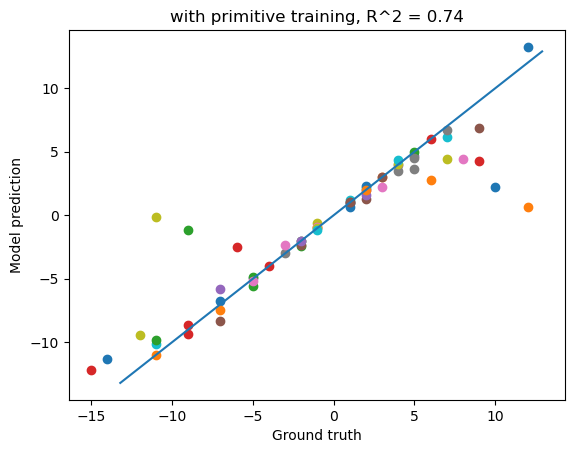

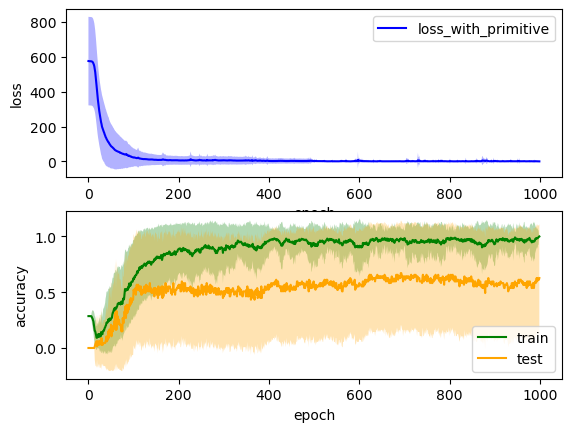

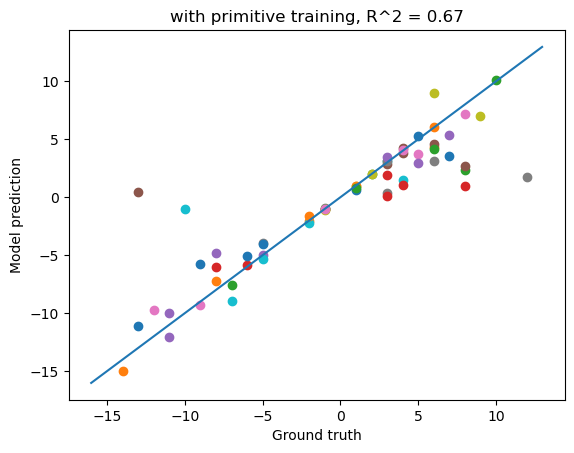

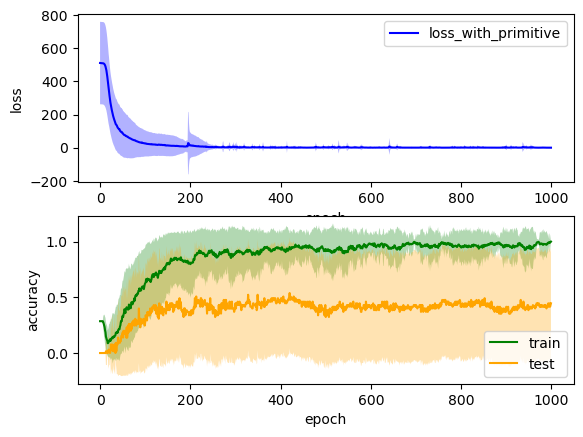

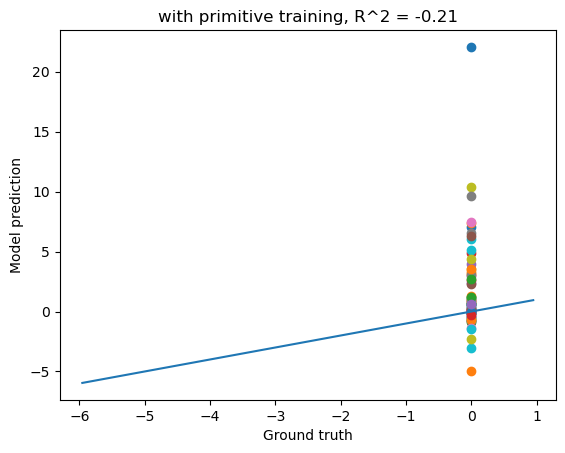

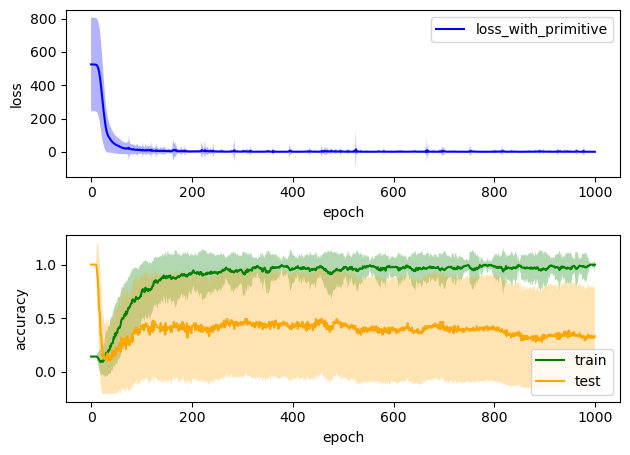

In [35]:
## primitive training
num_train = 3

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p + p_neg
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

In [ ]:
# 4 input symbols - 3 train trials

In [38]:
ops = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)


{'A': 12, 'B': 10, 'C': 9, 'D': 5}


trainseqs  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', -2], ['C', ('-', 'A'), '=', -3], ['A', '=', 12], ['B', '=', 10], ['C', '=', 9], ['D', '=', 5], [('-', 'A'), '=', -12], [('-', 'B'), '=', -10], [('-', 'C'), '=', -9], [('-', 'D'), '=', -5]]
testseqs  [['A', ('-', 'B'), '=', 2], ['A', ('-', 'C'), '=', 3], ['A', ('-', 'D'), '=', 7], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 1], ['B', ('-', 'D'), '=', 5], ['C', ('-', 'B'), '=', -1], ['C', ('-', 'C'), '=', 0], ['C', ('-', 'D'), '=', 4], ['D', ('-', 'A'), '=', -7], ['D', ('-', 'B'), '=', -5], ['D', ('-', 'C'), '=', -4], ['D', ('-', 'D'), '=', 0]]
run time:  4.078459986050924
57
total time:  4.08876218398412
57 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.09 
-----------



label      pred       acc
trial                                             
['D', '-', 'A', '=']  1.263158  1.386064  0.228070
['D', '-', 'D', '=']  0.000000  3.354334  0.157895
['B', '-', 'D', '=']  1.508772  3.705709  0.122807
['C', '-', 'D', '=']  1.298246  3.424764  0.105263
['A', '-', 'C', '='] -2.561404 -1.565895  0.087719
['C', '-', 'B', '='] -0.210526  2.839390  0.087719
['A', '-', 'B', '='] -2.771930 -1.826623  0.070175
['D', '-', 'B', '='] -1.508772  0.799474  0.070175
['A', '-', 'D', '='] -1.263158 -0.821223  0.052632
['B', '-', 'B', '=']  0.000000  4.136096  0.052632
['C', '-', 'C', '=']  0.000000  4.307811  0.035088
['D', '-', 'C', '='] -1.298246  1.129074  0.035088
['B', '-', 'C', '=']  0.210526  3.394602  0.000000

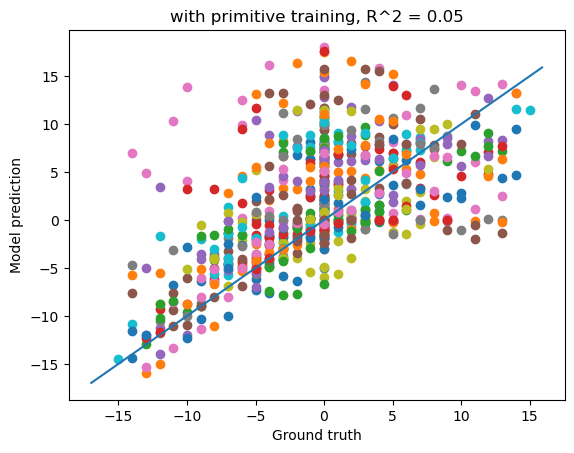

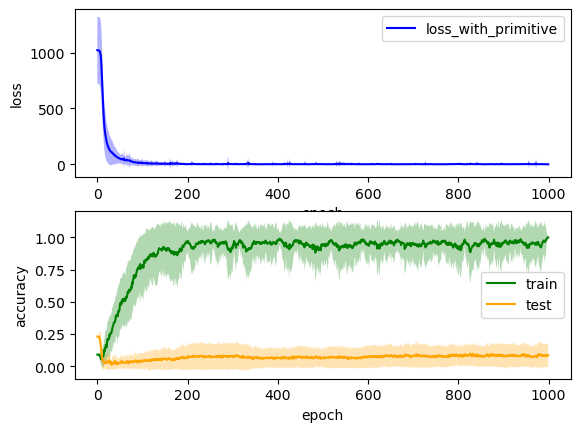

In [39]:
# row
trainseqs = generate_trials(ops, ['A'], ['A', 'B', 'C'])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res7 = run_plot(trainseqs, testseqs, cue_dict)
df7= res7['df_trials']
df7

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 2], ['A', ('-', 'C'), '=', 3], ['A', '=', 12], ['B', '=', 10], ['C', '=', 9], ['D', '=', 5], [('-', 'A'), '=', -12], [('-', 'B'), '=', -10], [('-', 'C'), '=', -9], [('-', 'D'), '=', -5]]
testseqs  [['A', ('-', 'D'), '=', 7], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 1], ['B', ('-', 'D'), '=', 5], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', -1], ['C', ('-', 'C'), '=', 0], ['C', ('-', 'D'), '=', 4], ['D', ('-', 'A'), '=', -7], ['D', ('-', 'B'), '=', -5], ['D', ('-', 'C'), '=', -4], ['D', ('-', 'D'), '=', 0]]
run time:  4.0301182190577185
57
total time:  4.037295401096344
57 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.08 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '=']  0.684211  0.396085  0.315789
['C', '-', 'B', '='] -0.596491 -0.057858  0.140351
['D', '-', 'C', '=']  0.736842  0.343196  0.122807
['C', '-', 'C', '=']  0.000000  0.300194  0.087719
['C', '-', 'A', '='] -1.421053 -1.216729  0.070175
['D', '-', 'A', '='] -0.684211 -1.258355  0.070175
['D', '-', 'B', '=']  0.140351  0.148778  0.070175
['B', '-', 'B', '=']  0.000000  0.766517  0.052632
['B', '-', 'A', '='] -0.824561 -0.267679  0.035088
['C', '-', 'D', '='] -0.736842 -0.605745  0.035088
['B', '-', 'C', '=']  0.596491  1.825736  0.017544
['B', '-', 'D', '='] -0.140351 -0.233441  0.017544
['D', '-', 'D', '=']  0.000000  0.172113  0.017544

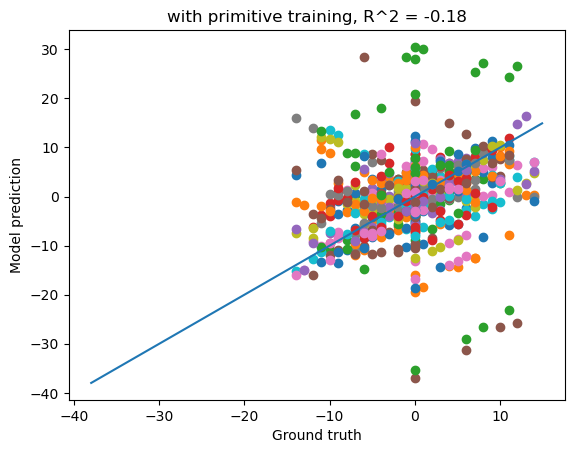

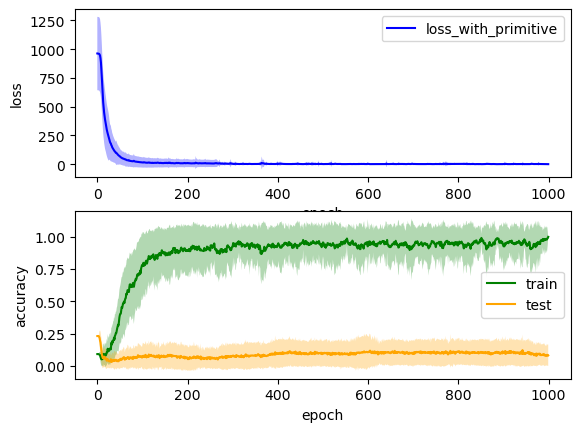

In [40]:
# col
trainseqs = generate_trials(ops, ['A', 'B', 'C'], ['A'])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res8 = run_plot(trainseqs, testseqs, cue_dict)
df8 = res8['df_trials']
df8

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 2], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -2], ['C', ('-', 'A'), '=', -3], ['A', '=', 12], ['B', '=', 10], ['C', '=', 9], ['D', '=', 5], [('-', 'A'), '=', -12], [('-', 'B'), '=', -10], [('-', 'C'), '=', -9], [('-', 'D'), '=', -5]]
testseqs  [['A', ('-', 'D'), '=', 7], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 1], ['B', ('-', 'D'), '=', 5], ['C', ('-', 'B'), '=', -1], ['C', ('-', 'C'), '=', 0], ['C', ('-', 'D'), '=', 4], ['D', ('-', 'A'), '=', -7], ['D', ('-', 'B'), '=', -5], ['D', ('-', 'C'), '=', -4], ['D', ('-', 'D'), '=', 0]]
run time:  4.298098500569662
60
total time:  4.304960298538208
60 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.27 
-----------



label      pred       acc
trial                                             
['B', '-', 'B', '=']  0.000000  1.019108  0.500000
['B', '-', 'C', '='] -0.183333  0.092263  0.483333
['C', '-', 'B', '=']  0.183333  0.292966  0.383333
['C', '-', 'C', '=']  0.000000  1.181018  0.383333
['A', '-', 'D', '=']  1.300000  1.110500  0.283333
['B', '-', 'D', '='] -0.183333 -0.606155  0.266667
['C', '-', 'D', '=']  0.000000 -0.029382  0.183333
['D', '-', 'A', '='] -1.300000 -0.515637  0.166667
['D', '-', 'B', '=']  0.183333  0.459695  0.150000
['D', '-', 'C', '=']  0.000000  1.039769  0.100000
['D', '-', 'D', '=']  0.000000  0.826991  0.100000

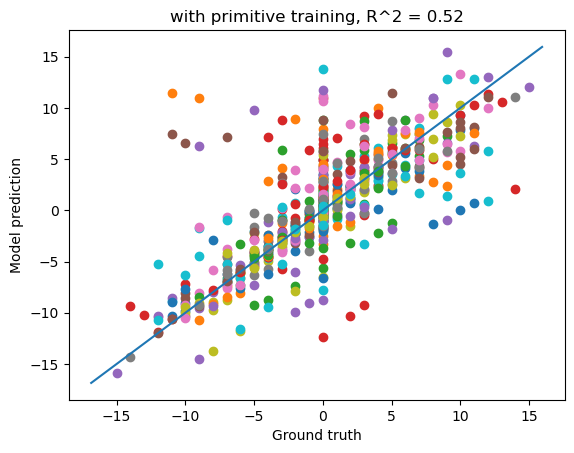

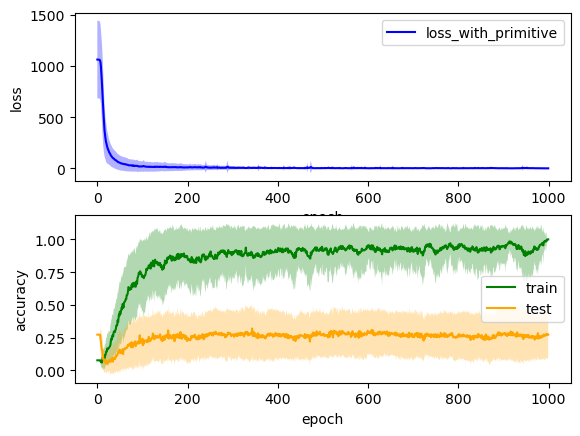

In [53]:
# corner
trainseqs = generate_trials(ops, ['A', 'B', 'C'], ['A'])+ generate_trials(ops, ['A'], ['B', 'C']) + p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res9 = run_plot(trainseqs, testseqs, cue_dict)
df9 = res9['df_trials']
df9

trainseqs  [['A', ('-', 'B'), '=', 2], ['B', ('-', 'C'), '=', 1], ['C', ('-', 'A'), '=', -3], ['A', '=', 12], ['B', '=', 10], ['C', '=', 9], ['D', '=', 5], [('-', 'A'), '=', -12], [('-', 'B'), '=', -10], [('-', 'C'), '=', -9], [('-', 'D'), '=', -5]]
testseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 3], ['A', ('-', 'D'), '=', 7], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'D'), '=', 5], ['C', ('-', 'B'), '=', -1], ['C', ('-', 'C'), '=', 0], ['C', ('-', 'D'), '=', 4], ['D', ('-', 'A'), '=', -7], ['D', ('-', 'B'), '=', -5], ['D', ('-', 'C'), '=', -4], ['D', ('-', 'D'), '=', 0]]
run time:  3.964922249317169
67
total time:  3.973568300406138
67 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.18 
-----------



label      pred       acc
trial                                             
['B', '-', 'A', '='] -0.223881  0.507649  0.253731
['C', '-', 'C', '=']  0.000000  1.623561  0.238806
['A', '-', 'A', '=']  0.000000  1.621792  0.223881
['A', '-', 'C', '=']  1.238806  1.597881  0.223881
['C', '-', 'B', '='] -1.014925 -0.356568  0.223881
['C', '-', 'D', '=']  0.089552 -0.088774  0.208955
['B', '-', 'B', '=']  0.000000  1.943225  0.194030
['B', '-', 'D', '=']  1.104478  0.995333  0.179104
['A', '-', 'D', '=']  1.328358  1.127866  0.164179
['D', '-', 'A', '='] -1.328358 -0.356747  0.164179
['D', '-', 'B', '='] -1.104478 -0.543740  0.119403
['D', '-', 'C', '='] -0.089552  0.623506  0.119403
['D', '-', 'D', '=']  0.000000  1.143248  0.074627

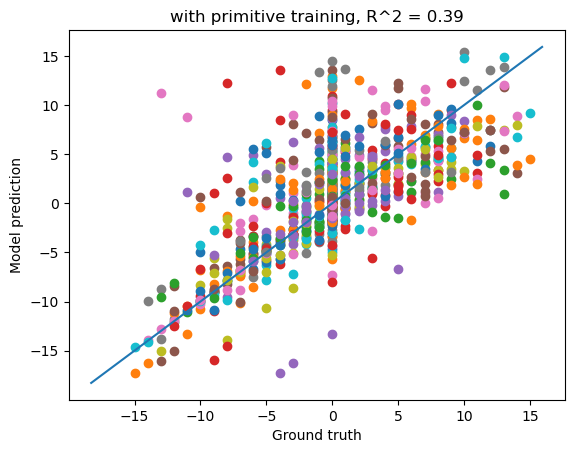

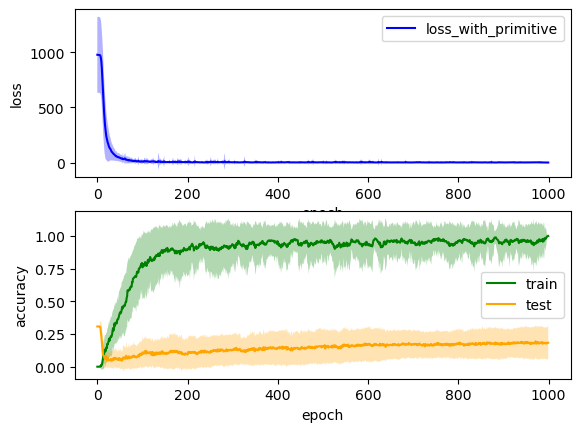

In [42]:
# other
trainseqs = generate_other(ops, ['A', 'B', 'C'])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res10 = run_plot(trainseqs, testseqs, cue_dict)
df10 = res10['df_trials']
df10

trainseqs  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', -2], ['C', ('-', 'B'), '=', -1], ['A', '=', 12], ['B', '=', 10], ['C', '=', 9], ['D', '=', 5], [('-', 'A'), '=', -12], [('-', 'B'), '=', -10], [('-', 'C'), '=', -9], [('-', 'D'), '=', -5]]
testseqs  [['A', ('-', 'B'), '=', 2], ['A', ('-', 'C'), '=', 3], ['A', ('-', 'D'), '=', 7], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 1], ['B', ('-', 'D'), '=', 5], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'C'), '=', 0], ['C', ('-', 'D'), '=', 4], ['D', ('-', 'A'), '=', -7], ['D', ('-', 'B'), '=', -5], ['D', ('-', 'C'), '=', -4], ['D', ('-', 'D'), '=', 0]]
run time:  3.893439785639445
59
total time:  3.90422838528951
59 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.16 
-----------



label      pred       acc
trial                                             
['C', '-', 'A', '='] -0.728814  0.255058  0.254237
['B', '-', 'D', '=']  0.440678  0.281343  0.203390
['C', '-', 'D', '=']  0.559322  0.743593  0.203390
['A', '-', 'C', '=']  0.728814 -0.485550  0.186441
['C', '-', 'C', '=']  0.000000  1.974382  0.186441
['D', '-', 'B', '='] -0.440678  0.457567  0.169492
['D', '-', 'D', '=']  0.000000  1.528883  0.169492
['A', '-', 'D', '=']  1.288136 -0.291680  0.152542
['B', '-', 'B', '=']  0.000000  1.422362  0.152542
['D', '-', 'C', '='] -0.559322  0.179686  0.152542
['B', '-', 'C', '='] -0.118644 -0.302441  0.135593
['A', '-', 'B', '=']  0.847458  0.019157  0.101695
['D', '-', 'A', '='] -1.288136 -0.161993  0.067797

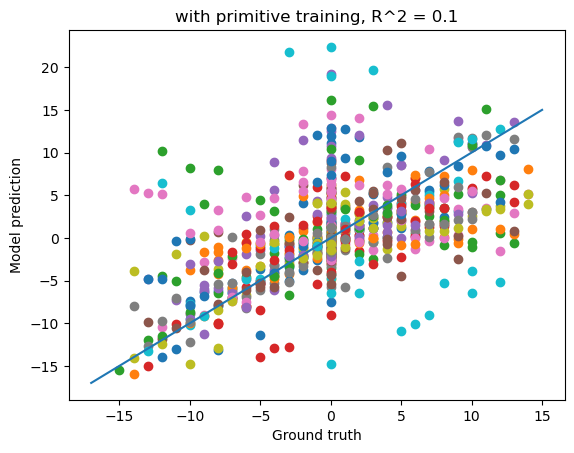

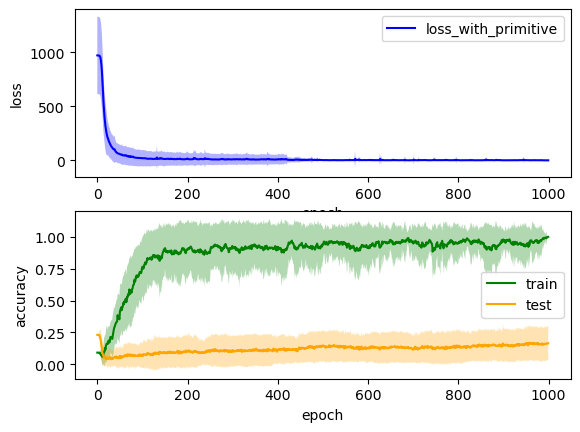

In [43]:
# mixed
trainseqs = generate_trials(ops,['A'], all_syms[:-2] ) + generate_trials(ops, ['B'], all_syms[-2])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res11 = run_plot(trainseqs, testseqs, cue_dict)
df11 = res11['df_trials']
df11

trainseqs  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 2], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -2], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 1], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', -1], ['C', ('-', 'C'), '=', 0], ['A', '=', 12], ['B', '=', 10], ['C', '=', 9], ['D', '=', 5], [('-', 'A'), '=', -12], [('-', 'B'), '=', -10], [('-', 'C'), '=', -9], [('-', 'D'), '=', -5]]
testseqs  [['A', ('-', 'D'), '=', 7], ['B', ('-', 'D'), '=', 5], ['C', ('-', 'D'), '=', 4], ['D', ('-', 'A'), '=', -7], ['D', ('-', 'B'), '=', -5], ['D', ('-', 'C'), '=', -4], ['D', ('-', 'D'), '=', 0]]
run time:  5.155538332462311
60
total time:  5.160796701908112
60 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.26 
-----------



label      pred       acc
trial                                             
['A', '-', 'D', '=']  0.850000  0.603402  0.450000
['B', '-', 'D', '=']  0.983333  0.728508  0.333333
['C', '-', 'D', '=']  0.800000  0.646118  0.333333
['D', '-', 'C', '='] -0.800000 -1.504118  0.200000
['D', '-', 'A', '='] -0.850000 -1.455921  0.183333
['D', '-', 'B', '='] -0.983333 -1.535500  0.183333
['D', '-', 'D', '=']  0.000000  0.243998  0.166667

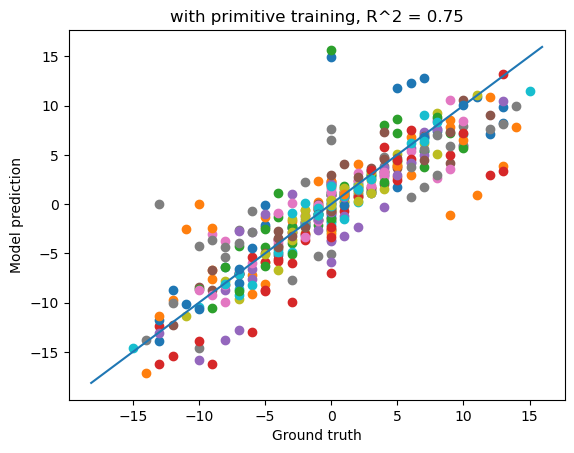

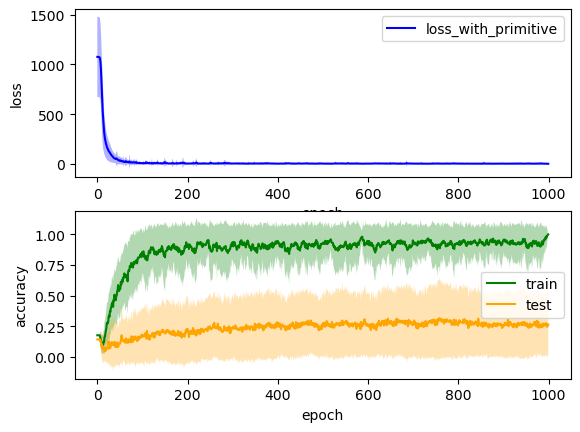

In [44]:
# df all
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res12 = run_plot(trainseqs, testseqs, cue_dict)
df12 = res12['df_trials']
df12

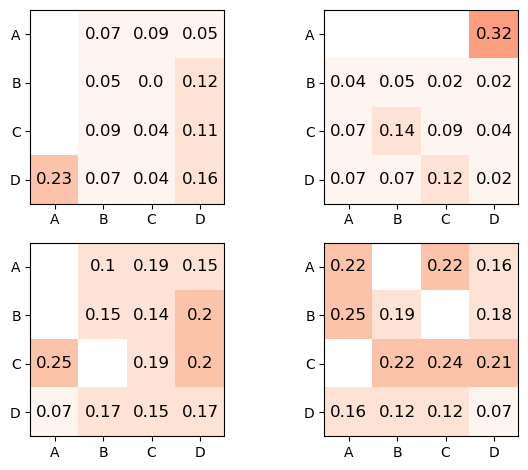

In [56]:
num_cols = 2
dfs = [df7, df8, df11, df10]
fig, axs = plt.subplots(2,2)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout() 

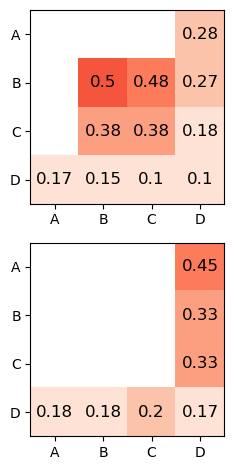

In [58]:
num_cols = 2
dfs = [df9, df12]
fig, axs = plt.subplots(2,1)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[i])
plt.tight_layout() 